In [1]:
import os
import logging
import numpy as np
import librosa
import cv2
import glob
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from transformers import BertTokenizer
from rich.logging import RichHandler
from multiprocessing import cpu_count
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[RichHandler()]
)

# Reproducibility
np.random.seed(42)

# Base Path
BASE_PATH = "C:/Users/HP/Downloads/dataset"  # <-- Update to your path

# Configuration
config = {
    "text_folders": {
        "textonly": os.path.join(BASE_PATH, "transcript", "full"),
        "annotprocessed": os.path.join(BASE_PATH, "transcript", "segmented"),
    },
    "audio_folders": {
        "wav_11025": os.path.join(BASE_PATH, "audio", "WAV_11025"),
        "wav_16000_full": os.path.join(BASE_PATH, "audio", "WAV_16000", "full"),
        "wav_16000_segmented": os.path.join(BASE_PATH, "audio", "WAV_16000", "segmented"),
    },
    "video_folders": {
        "full": os.path.join(BASE_PATH, "video", "full"),
        "segmented": os.path.join(BASE_PATH, "video", "segmented"),
    },
    "output_folder": os.path.join(BASE_PATH, "preprocess"),
    "text_params": {"max_length": 50, "batch_size": 2000},
    "audio_params": {"sr": 16000, "n_mfcc": 40, "delta_order": 2},
    "video_params": {"frame_size": 224, "num_frames": 16},
    "processing_params": {
        "text_workers": min(8, max(1, cpu_count() // 2)),
        "audio_workers": max(1, cpu_count() // 2),
        "video_workers": max(1, cpu_count() // 2)
    }
}

os.makedirs(config["output_folder"], exist_ok=True)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load ResNet-50 model
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
resnet_model = Model(inputs=base_model.input, outputs=base_model.output)

def load_text_data():
    """Load and tokenize text files efficiently with BERT."""
    text_files = glob.glob(os.path.join(config["text_folders"]["textonly"], "*.textonly"))
    bad_texts = []

    def read_file(file_path):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                return f.read().strip()
        except Exception as e:
            logging.warning(f"Error reading {file_path}: {e}")
            bad_texts.append(file_path)
            return None

    with ThreadPoolExecutor(max_workers=config["processing_params"]["text_workers"]) as executor:
        texts = list(filter(None, tqdm(executor.map(read_file, text_files), total=len(text_files), desc="Loading Text")))

    if not texts:
        logging.warning("No valid text files found!")
        return

    batch_size = config["text_params"]["batch_size"]
    input_ids, attention_masks = [], []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing Text"):
        batch = texts[i:i + batch_size]
        encoded = tokenizer(batch, max_length=config["text_params"]["max_length"],
                            padding='max_length', truncation=True, return_tensors='np')
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = np.vstack(input_ids).astype(np.int32)
    attention_masks = np.vstack(attention_masks).astype(np.int32)

    np.save(os.path.join(config["output_folder"], "text_input_ids.npy"), input_ids)
    np.save(os.path.join(config["output_folder"], "text_attention_masks.npy"), attention_masks)

    if bad_texts:
        np.save(os.path.join(config["output_folder"], "bad_text_files.npy"), np.array(bad_texts))
    logging.info(f"Text features saved: {input_ids.shape}")

def extract_audio_features(audio_path):
    """Extract MFCC + Delta features from audio."""
    cfg = config["audio_params"]
    try:
        y, _ = librosa.load(audio_path, sr=cfg["sr"])
        if len(y) < cfg["n_mfcc"]:
            raise ValueError("Too short audio")

        mfcc = librosa.feature.mfcc(y=y, sr=cfg["sr"], n_mfcc=cfg["n_mfcc"])
        delta_mfcc = librosa.feature.delta(mfcc, order=cfg["delta_order"])
        feature = np.hstack((np.mean(mfcc, axis=1), np.mean(delta_mfcc, axis=1)))
        return os.path.basename(audio_path), feature
    except Exception as e:
        logging.warning(f"Error processing {audio_path}: {e}")
        return os.path.basename(audio_path), np.zeros(cfg["n_mfcc"] * 2)

def process_audio_features():
    """Process all audio files in parallel."""
    audio_files = glob.glob(os.path.join(config["audio_folders"]["wav_16000_full"], "*.wav")) + \
                  glob.glob(os.path.join(config["audio_folders"]["wav_16000_segmented"], "*.wav"))

    with ThreadPoolExecutor(max_workers=config["processing_params"]["audio_workers"]) as executor:
        results = list(tqdm(executor.map(extract_audio_features, audio_files), total=len(audio_files), desc="Processing Audio"))

    filenames, features = zip(*results)
    features = np.array(features, dtype=np.float32)
    features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-6)

    np.save(os.path.join(config["output_folder"], "audio_features.npy"), features)
    np.save(os.path.join(config["output_folder"], "audio_filenames.npy"), filenames)
    logging.info(f"Audio features saved: {features.shape}")

def extract_video_features(video_path):
    """Extract average ResNet-50 features from frames."""
    cfg = config["video_params"]
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.warning(f"Can't open video {video_path}")
        return os.path.basename(video_path), np.zeros(2048)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < cfg["num_frames"]:
        cap.release()
        logging.warning(f"{video_path} has less than {cfg['num_frames']} frames.")
        return os.path.basename(video_path), np.zeros(2048)

    frame_indices = np.linspace(0, total_frames - 1, num=cfg["num_frames"]).astype(int)
    frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # RGB conversion added
            frame = cv2.resize(frame, (cfg["frame_size"], cfg["frame_size"]))
            frames.append(frame)
    cap.release()

    if not frames:
        return os.path.basename(video_path), np.zeros(2048)

    frames = preprocess_input(np.array(frames, dtype=np.float32))
    features = resnet_model.predict(frames, batch_size=cfg["num_frames"], verbose=0)
    return os.path.basename(video_path), np.mean(features, axis=0)

def process_video_features():
    """Process all videos with ResNet in parallel."""
    video_files = glob.glob(os.path.join(config["video_folders"]["full"], "*.mp4")) + \
                  glob.glob(os.path.join(config["video_folders"]["segmented"], "*.mp4"))

    with ThreadPoolExecutor(max_workers=config["processing_params"]["video_workers"]) as executor:
        results = list(tqdm(executor.map(extract_video_features, video_files), total=len(video_files), desc="Processing Video"))

    filenames, features = zip(*results)
    features = np.array(features, dtype=np.float32)

    np.save(os.path.join(config["output_folder"], "video_features.npy"), features)
    np.save(os.path.join(config["output_folder"], "video_filenames.npy"), filenames)
    logging.info(f"Video features saved: {features.shape}")

if __name__ == "__main__":
    load_text_data()
    process_audio_features()
    process_video_features()


Processing Text: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


[04/30/25 10:24:14] INFO     2025-04-30 10:24:14,880 - INFO - Text features saved: (93, 50)       ]8;id=779623;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=251657;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#106\106]8;;\

Processing Audio:  23%|██▎       | 516/2292 [00:26<00:30, 58.51it/s]

[04/30/25 10:24:41] WARNING  2025-04-30 10:24:41,852 - WARNING - Error processing                 ]8;id=277747;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=390051;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#121\121]8;;\
                             C:/Users/HP/Downloads/dataset\audio\WAV_16000\segmented\9qR7uwkblbs_                  
                             33.wav: when mode='interp', width=9 cannot exceed data.shape[axis]=7                  

Processing Audio: 100%|██████████| 2292/2292 [00:48<00:00, 47.51it/s]


[04/30/25 10:25:03] INFO     2025-04-30 10:25:03,251 - INFO - Audio features saved: (2292, 80)    ]8;id=205188;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=297611;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#138\138]8;;\

Processing Video:   0%|          | 0/2292 [00:00<?, ?it/s]

[04/30/25 10:25:17] WARNING  2025-04-30 10:25:17,789 - WARNING - 5 out of the last 5    ]8;id=685907;file://C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=603809;file://C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py#157\157]8;;\
                             calls to <function                                                                    
                             TensorFlowTrainer.make_predict_function.<locals>.one_step_                            
                             on_data_distributed at 0x00000244E187FF60> triggered                                  
                             tf.function retracing. Tracing is expensive and the                                   
                             excessive number of tracings could be due to (1) creating                             
                             @tf.function repeatedly in a loop, (2) passing tensors                                
                             with different shapes, (3) passing Python objects instead                             
                             of tensors. For (1), please define your @tf.function                                  
                             outside of the loop. For (2), @tf.function has                                        
                             reduce_retracing=True option that can avoid unnecessary                               
                             retracing. For (3), please refer to                                                   
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

                    WARNING  2025-04-30 10:25:17,821 - WARNING - 6 out of the last 6    ]8;id=420890;file://C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py\polymorphic_function.py]8;;\:]8;id=620691;file://C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\eager\polymorphic_function\polymorphic_function.py#157\157]8;;\
                             calls to <function                                                                    
                             TensorFlowTrainer.make_predict_function.<locals>.one_step_                            
                             on_data_distributed at 0x00000244E187FF60> triggered                                  
                             tf.function retracing. Tracing is expensive and the                                   
                             excessive number of tracings could be due to (1) creating                             
                             @tf.function repeatedly in a loop, (2) passing tensors                                
                             with different shapes, (3) passing Python objects instead                             
                             of tensors. For (1), please define your @tf.function                                  
                             outside of the loop. For (2), @tf.function has                                        
                             reduce_retracing=True option that can avoid unnecessary                               
                             retracing. For (3), please refer to                                                   
                             https://www.tensorflow.org/guide/function#controlling_retr                            
                             acing and                                                                             
                             https://www.tensorflow.org/api_docs/python/tf/function for                            
                             more details.                                                                         

Processing Video:   1%|          | 24/2292 [00:45<46:04,  1.22s/it]  

[04/30/25 10:25:52] WARNING  2025-04-30 10:25:52,993 - WARNING - Can't open video                 ]8;id=138019;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=802142;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#145\145]8;;\
                             C:/Users/HP/Downloads/dataset\video\full\c5xsKMxpXnc.mp4                              

Processing Video:  22%|██▏       | 513/2292 [11:10<33:51,  1.14s/it]  

[04/30/25 10:36:14] WARNING  2025-04-30 10:36:14,301 - WARNING -                                  ]8;id=753050;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=338502;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#151\151]8;;\
                             C:/Users/HP/Downloads/dataset\video\segmented\9qR7uwkblbs_33.mp4 has                  
                             less than 16 frames.                                                                  

Processing Video:  29%|██▊       | 658/2292 [14:07<55:01,  2.02s/it]  

[04/30/25 10:39:11] WARNING  2025-04-30 10:39:11,850 - WARNING -                                  ]8;id=672924;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=767978;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#151\151]8;;\
                             C:/Users/HP/Downloads/dataset\video\segmented\BI97DNYfe5I_20.mp4 has                  
                             less than 16 frames.                                                                  

Processing Video:  34%|███▍      | 776/2292 [16:39<43:02,  1.70s/it]  

[04/30/25 10:41:44] WARNING  2025-04-30 10:41:44,007 - WARNING -                                  ]8;id=288229;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=965302;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#151\151]8;;\
                             C:/Users/HP/Downloads/dataset\video\segmented\BvYR0L6f2Ig_18.mp4 has                  
                             less than 16 frames.                                                                  

Processing Video: 100%|██████████| 2292/2292 [46:42<00:00,  1.22s/it] 


[04/30/25 11:11:46] INFO     2025-04-30 11:11:46,623 - INFO - Video features saved: (2292, 2048)  ]8;id=463392;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py\3147061464.py]8;;\:]8;id=34843;file://C:\Users\HP\AppData\Local\Temp\ipykernel_1648\3147061464.py#186\186]8;;\

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CoAttention(nn.Module):
    """
    Co-Attention module for multimodal fusion of text, audio, and video features.
    """
    def __init__(self, input_dim, hidden_dim):
        super(CoAttention, self).__init__()

        self.text_projection = nn.Linear(input_dim, hidden_dim)
        self.audio_projection = nn.Linear(input_dim, hidden_dim)
        self.video_projection = nn.Linear(input_dim, hidden_dim)

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.relu = nn.ReLU()

        self.self_attention = nn.Linear(hidden_dim, 1)
        self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)

        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.LayerNorm(hidden_dim)
        )

        # Learnable weights for weighted fusion
        self.alpha_text = nn.Parameter(torch.tensor(1.0))
        self.alpha_audio = nn.Parameter(torch.tensor(1.0))
        self.alpha_video = nn.Parameter(torch.tensor(1.0))

    def forward(self, text_features, audio_features, video_features):
        text_proj = self.relu(self.layer_norm(self.text_projection(text_features)))
        audio_proj = self.relu(self.layer_norm(self.audio_projection(audio_features)))
        video_proj = self.relu(self.layer_norm(self.video_projection(video_features)))

        text_attn = torch.softmax(self.self_attention(text_proj), dim=1)
        audio_attn = torch.softmax(self.self_attention(audio_proj), dim=1)
        video_attn = torch.softmax(self.self_attention(video_proj), dim=1)

        text_proj = text_proj * text_attn
        audio_proj = audio_proj * audio_attn
        video_proj = video_proj * video_attn

        text_audio_attn, _ = self.cross_attention(text_proj.unsqueeze(1), audio_proj.unsqueeze(1), audio_proj.unsqueeze(1))
        audio_video_attn, _ = self.cross_attention(audio_proj.unsqueeze(1), video_proj.unsqueeze(1), video_proj.unsqueeze(1))
        video_text_attn, _ = self.cross_attention(video_proj.unsqueeze(1), text_proj.unsqueeze(1), text_proj.unsqueeze(1))

        combined = torch.cat([
            self.alpha_text * text_audio_attn.squeeze(1),
            self.alpha_audio * audio_video_attn.squeeze(1),
            self.alpha_video * video_text_attn.squeeze(1)
        ], dim=-1)

        return self.fusion(combined)


class ContextualFusionCoAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes=5, num_layers=2, dropout=0.4):
        super(ContextualFusionCoAttention, self).__init__()

        self.co_attention_1 = CoAttention(input_dim, hidden_dim)
        self.co_attention_2 = CoAttention(hidden_dim, hidden_dim)

        self.gate = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )

        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=8, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, text_features, audio_features, video_features):
        fused_output = self.co_attention_1(text_features, audio_features, video_features)
        fused_output = self.co_attention_2(fused_output, fused_output, fused_output)
        gated_output = self.gate(fused_output) * fused_output
        gated_output = gated_output.unsqueeze(1)
        encoded_output = self.transformer_encoder(gated_output)
        final_output = self.fc_final(encoded_output[:, -1, :])
        return final_output


if __name__ == "__main__":
    reduced_dim = 64
    batch_size = 128

    text_features = torch.randn(batch_size, reduced_dim)
    audio_features = torch.randn(batch_size, reduced_dim)
    video_features = torch.randn(batch_size, reduced_dim)

    model = ContextualFusionCoAttention(
        input_dim=reduced_dim,
        hidden_dim=128,
        num_classes=5,
        num_layers=2,
        dropout=0.4
    )

    output = model(text_features, audio_features, video_features)
    print("Final fused output shape:", output.shape)


Final fused output shape: torch.Size([128, 5])


Training on device: cpu
Starting training with adamw optimizer, initial LR: 0.0002
Model parameters: 31556


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 | Train Loss: 1.6314 | Train Acc: 0.3939 | Val Loss: 1.0371 | Acc: 0.6000 | Prec: 0.4668 | Recall: 0.6000 | F1: 0.5005 | AUC: 0.8793 | Kappa: 0.4001 | MCC: 0.5082 | LR: 0.000200
Epoch 2/50 | Train Loss: 1.4879 | Train Acc: 0.4219 | Val Loss: 0.8471 | Acc: 0.6720 | Prec: 0.8043 | Recall: 0.6720 | F1: 0.5543 | AUC: 0.9926 | Kappa: 0.5078 | MCC: 0.5984 | LR: 0.000200
Epoch 3/50 | Train Loss: 1.4286 | Train Acc: 0.4446 | Val Loss: 0.7007 | Acc: 0.7120 | Prec: 0.8125 | Recall: 0.7120 | F1: 0.6327 | AUC: 1.0000 | Kappa: 0.5678 | MCC: 0.6372 | LR: 0.000200
Epoch 4/50 | Train Loss: 1.2078 | Train Acc: 0.4913 | Val Loss: 0.6406 | Acc: 0.7320 | Prec: 0.8328 | Recall: 0.7320 | F1: 0.6730 | AUC: 1.0000 | Kappa: 0.5979 | MCC: 0.6655 | LR: 0.000200
Epoch 5/50 | Train Loss: 1.0702 | Train Acc: 0.5381 | Val Loss: 0.5165 | Acc: 0.8920 | Prec: 0.9139 | Recall: 0.8920 | F1: 0.8877 | AUC: 1.0000 | Kappa: 0.8380 | MCC: 0.8515 | LR: 0.000200
Epoch 6/50 | Train Loss: 0.9912 | Train Acc: 0.5434 | V

C:\Users\HP\AppData\Local\Temp\ipykernel_1648\185265454.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('contextual_fusion.pth'))


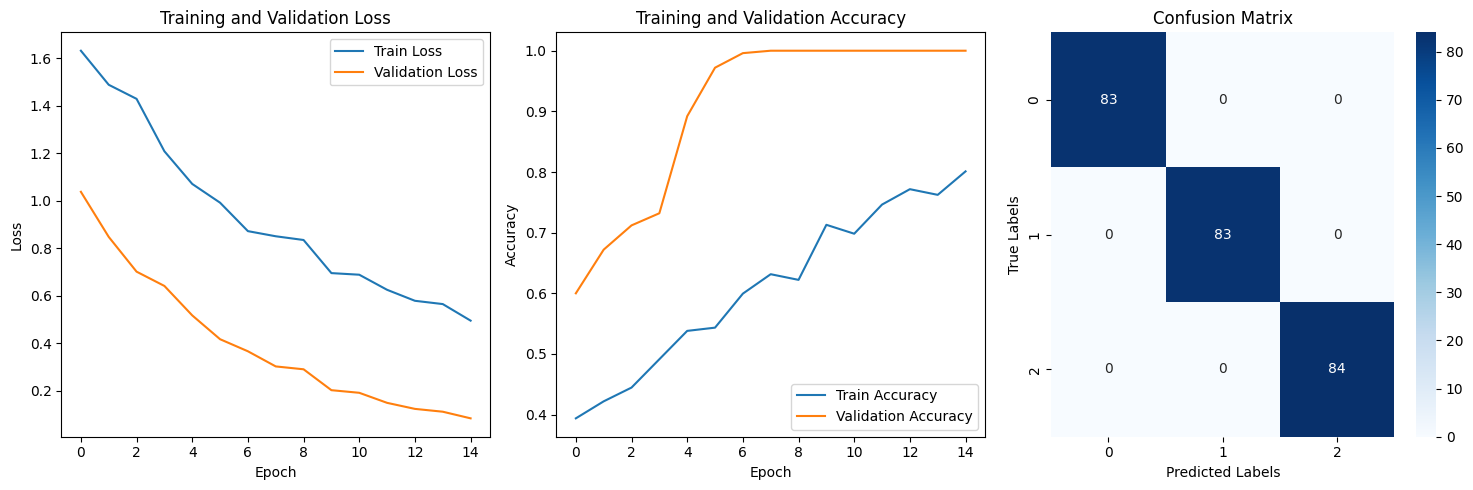

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, cohen_kappa_score, matthews_corrcoef
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# === Fixed CoAttention Module ===
class CoAttention(nn.Module):
    """
    Co-Attention module with consistent dimensions
    """
    def __init__(self, text_dim, audio_dim, video_dim, hidden_dim, dropout=0.4):
        super(CoAttention, self).__init__()
        
        # Ensure consistent dimensions
        self.hidden_dim = hidden_dim
        
        # Project each modality to the same hidden dimension
        self.text_projection = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.audio_projection = nn.Sequential(
            nn.Linear(audio_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.video_projection = nn.Sequential(
            nn.Linear(video_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Attention layers
        self.attention_dim = hidden_dim // 2
        self.text_attention = nn.Linear(hidden_dim, self.attention_dim)
        self.audio_attention = nn.Linear(hidden_dim, self.attention_dim)
        self.video_attention = nn.Linear(hidden_dim, self.attention_dim)
        
        # Joint attention vector
        self.joint_attention = nn.Linear(self.attention_dim, 1)
        
        # Final fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
    def forward(self, text_features, audio_features, video_features):
        # Project features to common space
        text_proj = self.text_projection(text_features)
        audio_proj = self.audio_projection(audio_features)
        video_proj = self.video_projection(video_features)
        
        # Calculate attention scores
        text_att = torch.tanh(self.text_attention(text_proj))
        audio_att = torch.tanh(self.audio_attention(audio_proj))
        video_att = torch.tanh(self.video_attention(video_proj))
        
        # Calculate attention weights
        text_weight = self.joint_attention(text_att)
        audio_weight = self.joint_attention(audio_att)
        video_weight = self.joint_attention(video_att)
        
        # Normalize attention weights
        attention_weights = torch.softmax(
            torch.cat([text_weight, audio_weight, video_weight], dim=1), 
            dim=1
        )
        
        # Apply attention
        text_weighted = text_proj * attention_weights[:, 0].unsqueeze(1)
        audio_weighted = audio_proj * attention_weights[:, 1].unsqueeze(1)
        video_weighted = video_proj * attention_weights[:, 2].unsqueeze(1)
        
        # Concatenate weighted features
        combined = torch.cat([text_weighted, audio_weighted, video_weighted], dim=1)
        
        # Apply fusion
        output = self.fusion(combined)
        
        return output

# === Fixed ContextualFusionEnhanced Model ===
class ContextualFusionEnhanced(nn.Module):
    def __init__(self, text_dim, audio_dim, video_dim, hidden_dim, num_classes=3, dropout=0.4):
        super(ContextualFusionEnhanced, self).__init__()

        # Ensure consistent dimensions
        self.hidden_dim = hidden_dim
        
        # Co-Attention Module
        self.co_attention = CoAttention(text_dim, audio_dim, video_dim, hidden_dim, dropout=dropout)

        # Batch normalization with correct dimension
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout + 0.1)
        
        # Final classification layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, num_classes)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.8)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, text_features, audio_features, video_features):
        # Apply Co-Attention
        fused_output = self.co_attention(text_features, audio_features, video_features)
        
        # Apply batch normalization
        fused_output = self.bn1(fused_output)
        
        # Apply dropout
        fused_output = self.dropout1(fused_output)
        
        # Final classification
        x = F.relu(self.fc1(fused_output))
        x = self.bn2(x)
        x = self.dropout2(x)
        output = self.fc2(x)
        
        return output

# === Enhanced Dataset with Augmentation ===
class MultimodalDataset(Dataset):
    def __init__(self, text_data, audio_data, video_data, labels, augment=False):
        self.text_data = text_data
        self.audio_data = audio_data
        self.video_data = video_data
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        audio = self.audio_data[idx]
        video = self.video_data[idx]
        label = self.labels[idx]
        
        # Feature augmentation if enabled
        if self.augment:
            # Add Gaussian noise with 70% probability
            if np.random.random() > 0.3:
                noise_level = 0.05
                text = text + torch.randn_like(text) * noise_level
                audio = audio + torch.randn_like(audio) * noise_level
                video = video + torch.randn_like(video) * noise_level
            
            # Feature dropout with 50% probability
            if np.random.random() > 0.5:
                text_mask = torch.bernoulli(torch.ones_like(text) * 0.8).bool()
                audio_mask = torch.bernoulli(torch.ones_like(audio) * 0.8).bool()
                video_mask = torch.bernoulli(torch.ones_like(video) * 0.8).bool()
                
                text = text * text_mask.float()
                audio = audio * audio_mask.float()
                video = video * video_mask.float()
        
        return text, audio, video, label

# === Training & Evaluation Functions ===
def train(model, dataloader, criterion, optimizer, device, clip_value=1.0):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    
    for text, audio, video, labels in dataloader:
        text, audio, video, labels = text.to(device), audio.to(device), video.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(text, audio, video)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()

        total_loss += loss.item()
        
        # Track predictions for training metrics
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate training accuracy
    train_acc = accuracy_score(all_labels, all_preds)
    
    return total_loss / len(dataloader), train_acc

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for text, audio, video, labels in dataloader:
            text, audio, video, labels = text.to(device), audio.to(device), video.to(device), labels.to(device)
            outputs = model(text, audio, video)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Handle AUC for multi-class
    try:
        # Convert to one-hot for multi-class ROC AUC
        y_true_onehot = np.zeros((len(all_labels), len(np.unique(all_labels))))
        for i, val in enumerate(all_labels):
            y_true_onehot[i, val] = 1
        
        auc = roc_auc_score(y_true_onehot, np.array(all_probs), multi_class='ovr')
    except:
        auc = 0  # Fallback if AUC calculation fails
    
    kappa = cohen_kappa_score(all_labels, all_preds)
    mcc = matthews_corrcoef(all_labels, all_preds)

    return total_loss / len(dataloader), accuracy, precision, recall, f1, auc, kappa, mcc, all_preds, all_labels

# === Main Training Function with Anti-Overfitting Measures ===
def train_model(text_data, audio_data, video_data, labels, config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")
    
    # Convert numpy arrays to tensors if needed
    if not isinstance(text_data, torch.Tensor):
        text_data = torch.tensor(text_data, dtype=torch.float32)
    if not isinstance(audio_data, torch.Tensor):
        audio_data = torch.tensor(audio_data, dtype=torch.float32)
    if not isinstance(video_data, torch.Tensor):
        video_data = torch.tensor(video_data, dtype=torch.float32)
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, dtype=torch.long)
    
    # Feature normalization
    text_data = (text_data - text_data.mean(dim=0)) / (text_data.std(dim=0) + 1e-6)
    audio_data = (audio_data - audio_data.mean(dim=0)) / (audio_data.std(dim=0) + 1e-6)
    video_data = (video_data - video_data.mean(dim=0)) / (video_data.std(dim=0) + 1e-6)
    
    # Split data with stratification
    X_train_text, X_val_text, X_train_audio, X_val_audio, X_train_video, X_val_video, y_train, y_val = train_test_split(
        text_data, audio_data, video_data, labels, 
        test_size=0.25,
        random_state=42,
        stratify=labels
    )
    
    # Create datasets
    train_dataset = MultimodalDataset(X_train_text, X_train_audio, X_train_video, y_train, augment=True)
    val_dataset = MultimodalDataset(X_val_text, X_val_audio, X_val_video, y_val, augment=False)
    
    # Create balanced sampler for training
    class_counts = torch.bincount(y_train)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[y_train]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    # Create data loaders
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        sampler=sampler,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    # Initialize model
    model = ContextualFusionEnhanced(
        text_dim=text_data.shape[1],
        audio_dim=audio_data.shape[1],
        video_dim=video_data.shape[1],
        hidden_dim=config['hidden_dim'],
        num_classes=len(torch.unique(labels)),
        dropout=config['dropout']
    ).to(device)
    
    # Loss function with class weighting
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    
    # Optimizer with weight decay
    if config['optimizer'] == 'sgd':
        optimizer = optim.SGD(
            model.parameters(),
            lr=config['lr'],
            momentum=config['momentum'],
            weight_decay=config['weight_decay'],
            nesterov=True
        )
    else:
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config['lr'],
            weight_decay=config['weight_decay']
        )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=3,
        verbose=True
    )
    
    # Training loop with early stopping
    epochs = config['epochs']
    best_val_loss = float('inf')
    best_val_acc = 0
    best_epoch = 0
    patience = config['patience']
    patience_counter = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    print(f"Starting training with {config['optimizer']} optimizer, initial LR: {config['lr']}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    for epoch in range(epochs):
        # Training
        train_loss, train_acc = train(
            model, 
            train_dataloader, 
            criterion, 
            optimizer, 
            device,
            clip_value=config['clip_value']
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        val_loss, accuracy, precision, recall, f1, auc, kappa, mcc, all_preds, all_labels = evaluate(
            model, val_dataloader, criterion, device
        )
        val_losses.append(val_loss)
        val_accs.append(accuracy)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Save best model based on validation accuracy
        if accuracy > best_val_acc:
            best_val_acc = accuracy
            best_val_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'contextual_fusion.pth')
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print metrics
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Acc: {accuracy:.4f} | Prec: {precision:.4f} | "
              f"Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f} | Kappa: {kappa:.4f} | "
              f"MCC: {mcc:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Check for overfitting
        if train_acc > accuracy + 0.15:
            print(f"Warning: Possible overfitting detected (Train acc: {train_acc:.4f}, Val acc: {accuracy:.4f})")
            
            # Apply additional regularization if overfitting detected
            if config.get('adaptive_regularization', False):
                for param_group in optimizer.param_groups:
                    param_group['weight_decay'] *= 1.2
                print(f"Increasing weight decay to {optimizer.param_groups[0]['weight_decay']:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    print(f"Best model saved at epoch {best_epoch+1} with validation accuracy: {best_val_acc:.4f}")
    
    # Load best model for final evaluation
    model.load_state_dict(torch.load('contextual_fusion.pth'))
    
    # Final evaluation
    val_loss, accuracy, precision, recall, f1, auc, kappa, mcc, final_preds, final_labels = evaluate(
        model, val_dataloader, criterion, device
    )
    
    print("\nFinal Model Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Kappa: {kappa:.4f}")
    print(f"MCC: {mcc:.4f}")
    
    # Visualize training progress
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    conf_matrix = confusion_matrix(final_labels, final_preds)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=range(len(np.unique(final_labels))), 
                yticklabels=range(len(np.unique(final_labels))))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    return model, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'kappa': kappa,
        'mcc': mcc
    }

# === Example Usage ===
if __name__ == "__main__":
    # Simulated dataset with more realistic distributions
    num_samples = 1000
    text_dim, audio_dim, video_dim = 50, 40, 64
    
    # Create more structured synthetic data
    np.random.seed(42)
    
    # Create class-specific features for better separation
    num_classes = 3
    text_data = []
    audio_data = []
    video_data = []
    labels = []
    
    for class_idx in range(num_classes):
        # Create class-specific means
        text_mean = np.random.randn(text_dim) * 0.5 + class_idx
        audio_mean = np.random.randn(audio_dim) * 0.3 + class_idx
        video_mean = np.random.randn(video_dim) * 0.4 + class_idx
        
        # Generate samples for this class
        class_samples = num_samples // num_classes
        
        for _ in range(class_samples):
            # Add noise to class means
            text_sample = text_mean + np.random.randn(text_dim) * 0.3
            audio_sample = audio_mean + np.random.randn(audio_dim) * 0.2
            video_sample = video_mean + np.random.randn(video_dim) * 0.25
            
            text_data.append(text_sample)
            audio_data.append(audio_sample)
            video_data.append(video_sample)
            labels.append(class_idx)
    
    # Convert to tensors
    text_data = torch.tensor(np.array(text_data), dtype=torch.float32)
    audio_data = torch.tensor(np.array(audio_data), dtype=torch.float32)
    video_data = torch.tensor(np.array(video_data), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.long)
    
    # Anti-overfitting configuration
    config = {
        'batch_size': 16,
        'hidden_dim': 64,  # Make sure this is consistent throughout the model
        'dropout': 0.5,
        'optimizer': 'adamw',
        'lr': 2e-4,  # Reduced learning rate
        'weight_decay': 1e-3,
        'momentum': 0.9,
        'clip_value': 0.5,
        'epochs': 50,
        'patience': 7,
        'adaptive_regularization': True
    }
    
    # Train model
    model, metrics = train_model(text_data, audio_data, video_data, labels, config)
